In [1]:
import msprime, tskit
from IPython.display import SVG
import numpy as np
import matplotlib.pyplot as plt
from algorithm import *

In [2]:
ts2 = msprime.sim_ancestry(3, population_size=100, sequence_length=1e5, recombination_rate=1e-8,
                         record_full_arg=True)

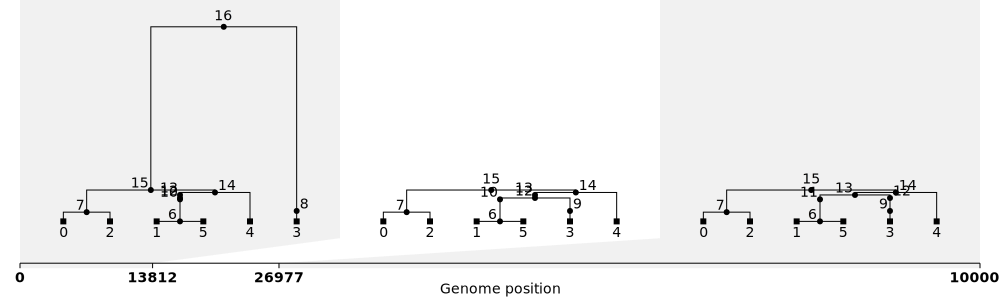

In [3]:
SVG(ts2.draw_svg(size=(1000, 300), x_lim=[0, 1e5]))

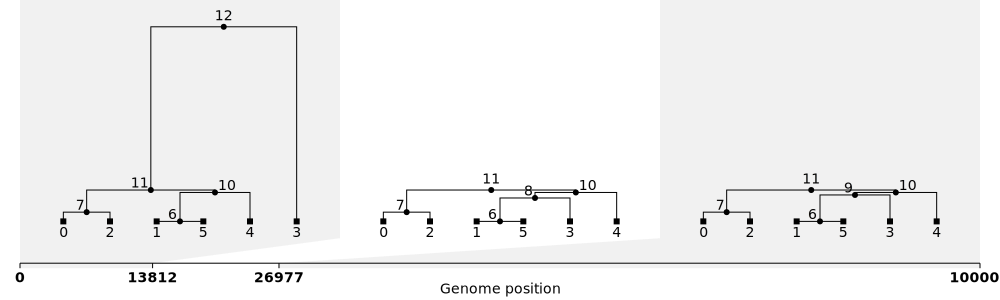

In [4]:
sts = ts2.simplify()
SVG(sts.draw_svg(size=(1000, 300), x_lim=[0, 1e5]))

[16, 15]


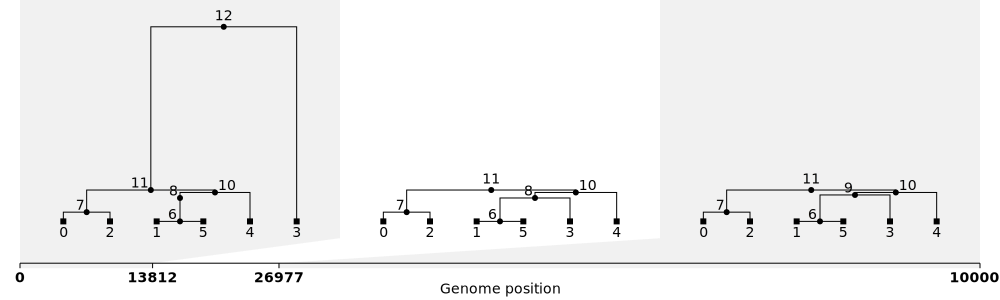

In [5]:
ts1, n = extend_edges(sts)
print(n)
SVG(ts1.draw_svg(size=(1000, 300), x_lim=[0, 1e5]))

Our goal is to construct a function to measure the number of discrepancies between our inferred tree sequence $TS_1$ and the ground truth $TS_2$. For tree sequences $TS_1$ and $TS_2$ both of sequence length $L$, each have nodes at position $i$ in the genome, $x$ and $y$ respectively. From these nodes we count the number of samples which stem from them. We define these sets as $D_1(i,x)$ and $D_2(i,y)$. We count the number of descrepancies between the nodes $x$ and $y$ as their set difference, $|D_1(i,x)\vartriangle D_2(i,y)|$. We define the $\textbf{discrepancy number}$ between nodes $x$ and $y$ as 
$$ d(x,y) = \sum_{i=0}^{L-1} |D_1(i,x)\vartriangle D_2(i,y)|. $$
Using this we generalize to find the number of discrepancies between a node $x$ and the ground truth $TS_2$,
$$ d(x,TS_2) = \inf_{y\in TS_2.nodes()} d(x,y).$$
Finally, to compute the number of discrepancies between tree sequences we use the function
$$d(TS_1,TS_2) = \sum_{x\in TS_1.nodes()} d(x,TS_2)=\sum_{x\in TS_1.nodes()} \inf_{y\in TS_2.nodes()} d(x,y) = \sum_{x\in TS_1.nodes()} \inf_{y\in TS_2.nodes()} \sum_{i=0}^{L-1} |D_1(i,x)\vartriangle D_2(i,y)|,$$
and call this the $\textbf{discrepancy number}$ between $TS_1$ and $TS_2$.

In [6]:
def node_discrepancy(x, ts1, y, ts2):
    # function to return the discrepancy number between two nodes, d(x,y)
    dis = 0
    for interval, t1, t2 in ts1.coiterate(ts2):
        s = interval.span
        Dx = set(t1.samples(x))
        for z in t2.samples(y):
            if z not in Dx:
                dis += s
    return dis

def node_tree_discrepancy(x, ts1, ts2): # I tried to make the function faster, I am not sure if it does though
    # function to return the discrepancy number between a node and tree sequence d(x,TS2)
    dis = ts2.sequence_length
    for y in range(ts2.num_nodes):
        xydis = node_discrepancy(x, ts1, y, ts2)
        if xydis < dis:
            dis = xydis
    
    return dis # Perhaps we could also have this function also return a list of the nodes which give us the minimal discrepancy number

def node_tree_discrepancy2(x, ts1, ts2):
    dis = np.zeros(ts2.num_nodes)
    for interval, t1, t2 in ts1.coiterate(ts2):
        s = interval.span
        Dx = set(t1.samples(x))
        for y in t2.nodes():
            n = len(set(t2.samples(y)) - Dx)
            dis[y] += n * s
    return np.min(dis)

In [8]:
num_samples = 10
tsA = msprime.sim_ancestry(num_samples, population_size=1000, sequence_length=1e5,
                           recombination_rate=1e-8, record_full_arg=True)
tsB = msprime.sim_ancestry(num_samples, population_size=1000, sequence_length=1e5,
                           recombination_rate=1e-8, record_full_arg=True)
for j in range(10):
    assert np.all(node_tree_discrepancy(j, tsA, tsA) == 0)
    assert np.all(node_tree_discrepancy2(j, tsA, tsA) == 0)
    assert np.allclose(
        node_tree_discrepancy(j, tsA, tsB),
        node_tree_discrepancy2(j, tsA, tsB)
    )

In [9]:
def discrepancy(ts1, ts2):
    dis = 0
    
    for n in range(ts1.num_nodes):
        dis += node_tree_discrepancy2(n,ts1,ts2)
    return dis

In [10]:
discrepancy(ts1, ts2)

0.0

Now we should run an experiment to see with our new metric the varying distribution of the disscrepancy number between the simulated tree sequence and its edge extended version.

In [13]:
for num_samples in [3, 5,7,9]:
    for L in [1e4, 1e5]: #, 1e6,1e7]:
        ts = msprime.sim_ancestry(num_samples, population_size=1000, sequence_length=L,
                                  recombination_rate=1e-8, record_full_arg=True)
        sts = ts.simplify()
        
        ext_sts, _ = extend_edges(sts)
        #dd = orig_discrepancy(ext_sts, ts)
        d = discrepancy(ext_sts, ts)
        print(f'number of samples = {num_samples}, length = {L}\n original discrepancy number = {d}')

number of samples = 3, length = 10000.0
 original discrepancy number = 0.0
number of samples = 3, length = 100000.0
 original discrepancy number = 158.0
number of samples = 5, length = 10000.0
 original discrepancy number = 0.0
number of samples = 5, length = 100000.0
 original discrepancy number = 0.0
number of samples = 7, length = 10000.0
 original discrepancy number = 0.0
number of samples = 7, length = 100000.0
 original discrepancy number = 0.0
number of samples = 9, length = 10000.0
 original discrepancy number = 0.0
number of samples = 9, length = 100000.0
 original discrepancy number = 0.0


# TODO: explain what happens here

In [14]:
def node_tree_discrepancy3(x, ts1, ts2):
    sim = np.zeros(ts2.num_nodes)
    for interval, t1, t2 in ts1.coiterate(ts2):
        s = interval.span
        # note that Dx might not have changed since the last tree
        Dx = set(t1.samples(x))
        if len(Dx) > 1:
            y = t2.mrca(*list(Dx))
            sim[y] += (set(t2.samples(y)) == Dx) * s
    return ts1.sequence_length - np.max(sim)

In [15]:
def discrepancy3(ts1, ts2):
    dis = 0
    for n in range(ts1.num_nodes):
        dis += node_tree_discrepancy3(n, ts1, ts2)
    return dis


TODO:

1. write down the math for this new definition
2. IS THIS RIGHT, EVEN?
3. check whether dis(ts1, ts2) = dis(ts2, ts1) = 0 then ts1 == ts2?
4. make a plot of runtime of dis( ) as a function of number of nodes? of trees?


# new definition, take 2

For a tree sequence $T$ and a node $x$ and position $i$, let $D_T(x, i)$ be the set of descendant
samples of $x$ in $T$ at position $i$, and for node $x$ in $T_1$ and node $y$ in $T_2$, where both $T_j$
are tree sequences of length $L$, let
$$
   \rho_{T_1, T_2}(x, y)
   =
   \frac{1}{L} \sum_i \left[ D_{T_1}(x, i) == D_{T_2}(y, i) \right],
$$
where the thing in the $[ ]$'s means that it should be 1 if True, 0 if False.
This is the fraction of the sequence along which $x$ and $y$ have exactly the same descendant set
(and so is a similiarity).
Then, let
$$
  d(x, T_1, T_2) = \min_y \left\{ 1 - \rho_{T_1, T_2}(x, y) \right\} ,
$$
which is the proportion of the genome over which the descendant set of $x$ *does not* match
that of $y$, where $y$ is it's (global) best matching node.

Note that this is *different* than
$$
   \frac{1}{L} \sum_i \min_y \left(1 - \left[ D_{T_1}(x, i) == D_{T_2}(y, i) \right]\right),
$$
which would tell us the proportion of the genome over which $x$ does not have a perfectly matching node,
i.e., a node which has exactly the same descendant set.

We are doing this because want to find the node $y$ that is the best match over the whole genome,
since this tells us how well nodes are identified across trees.

## Thoughts:

Here are some properties we'd like our dissimiarity to satisfy:

1. interpretable
2. computable
3. measuring what we want

More concretely,

- smaller changes to the trees should not have larger effects on dissimiliarity

Note that in the definition above, moving a bigger subtree actually has a larger effect on dissimiliarty
than moving a smaller subtree, because all nodes on the path from the old place the subtree was attached
to the new place are affected.

*Question:* What is a notion of monotonicity that we could use here (ie what's "smaller")?

Another observation:

- what if a node has an exact match to different other nodes on two halves of the genome;
   shouldn't this be better than if it just doesn't match anyone on half the genome?

*Note:* there are two dimensions here: sequence length; and how much descendant sets differ;
and there is some interplay between the two.

*Observation:* we could modify the definition above to be
$$
   \rho_{T_1, T_2}(x, y)
   =
   \frac{1}{L} \sum_i f(|D_{T_1}(x, i)|) \left[ D_{T_1}(x, i) == D_{T_2}(y, i) \right],
$$
for some function $f$ of the size of the set
(e.g., if $f(w) = 1/w$ then we'd be downweighting mismatches on large descendant sets,
which might make sense because if a node doesn't match then probably their descedant nodes don't match either).

### 1. New Definition
The computation time to compute our previous metric scales with $n^2$ where $n$ is the number of nodes in $TS_2$. This drags runtime even with tree sequences with length $10^7$. To mitigate this we are tweaking our definition of our metric to try and minimize computation time. We rewrite our function representing the discrepancy between a node $x\in TS_1$ and $TS_2$, and do so by trying to find similarities between the tree sequences. For a node $x$ we compute $D_1(i,x)$ which is the set of descendent samples of $x$. If $|D_1(i,x)|>1$ we then look for the most recent common anscestors (mrca) of $D_1(i,x)$ in $TS_2$ and we call this node $y$. We then check if $D_1(i,x) = D_2(i,y)$ as sets and if this is true then we set $d(x,y)=1$. This helps us define our node-tree discrepancy function as
$$d(x,TS_2) = \min_y \{L_2 - d(x,y)\cdot l_i\},$$
where $L_2$ is the length of $TS_2$, and $l_i$ is the length of the interval between the coiteration of trees between $TS_1$ and $TS_2$ where $y\in t_2$ and $x\in t_1$. (This could be written better). $\newline$ 
Additionally I think there should be some scaling involved, however we have not fully thought of any good options for this.

### 2. Is this even right? 
I am not fully sure that `node_tree_discrepancy3` is entirely correct. I think we want to find similarities between $x$ and $y$ where `y=t2.mrca(*Dx)` and $Dx = D_1(treeindex, x)$. Were running a for loop over the coiteration between TS1 and TS2 and so each tuple we compute `Dx` and we find $y$ if `len(Dx)>1`. I think we should be summing over all nonzero elements in `dis` and then subtract it from the length of TS2. I think this would better track the dissimilarity between the tree sequences as we would be tracking similarities of node $x$ over all of the trees it is in instead of just one tree in a particular part of the coiteration (granted I could be really misinterpretting what this coiteration function does). Additionally, if the approach I am suggesting is given we would also have to account for is `len(Dx)=1`. This could be done by checking in `t2` if there exists a node with just that sample as is only descendant. I will attempt to write the function below.

In [16]:
def node_tree_discrepancy4(x, ts1, ts2):
    dis = np.zeros(ts2.num_nodes)
    
    for interval, t1, t2 in ts1.coiterate(ts2):
        s = interval.span
        
        Dx = set(t1.samples(x))
        if len(Dx) > 1:
            y = t2.mrca(*list(Dx))
            Dy = set(t2.samples(y))
            dis[y] = (Dy == Dx)*s
        if len(Dx) == 1:
            y = t2.parent(list(Dx)[0])
            Dy = set(t2.samples(y))
            dis[y] = (Dy == Dx)*s
    return ts2.sequence_length - np.sum(dis)

In [17]:
def discrepancy4(ts1, ts2):
    dis = 0
    
    for n in range(ts1.num_nodes):
        dis += node_tree_discrepancy4(n,ts1,ts2)
    return dis

### 3. Check $d(TS_1,TS_2) = d(TS_2,TS_1) = 0 \Longrightarrow TS_1=TS_2$, or even $d(TS_1,TS_2)=0 \Longrightarrow TS_1\subset TS_2$.
Suppose that $d(TS_1,TS_2)=d(TS_2,TS_1)=0$. Then we eventually do the math to make this check.

### 4. Make a plot of runtime of $d(TS_1,TS_2)$ as a function of number of nodes/trees/both.
TBD

In [18]:
# I am very confused why this wont run for me. mrca should be able to take more than 3 arguments correct?
for num_samples in [3, 5,7,9]:
    for L in [1e4, 1e5, 1e6,1e7]:
        ts = msprime.sim_ancestry(num_samples, population_size=1000, sequence_length=L,
                                  recombination_rate=1e-8, record_full_arg=True)
        sts = ts.simplify()
        
        ext_sts, _ = extend_edges(sts)
        d = discrepancy4(ext_sts, ts)
        print(f'number of samples = {num_samples}, length = {L}\n original discrepancy number = {d}')

number of samples = 3, length = 10000.0
 original discrepancy number = 85020.0
number of samples = 3, length = 100000.0
 original discrepancy number = 1199380.0
number of samples = 3, length = 1000000.0
 original discrepancy number = 52796845.0
number of samples = 3, length = 10000000.0
 original discrepancy number = 4938857703.0
number of samples = 5, length = 10000.0
 original discrepancy number = 156314.0
number of samples = 5, length = 100000.0
 original discrepancy number = 2117768.0
number of samples = 5, length = 1000000.0
 original discrepancy number = 94367962.0
number of samples = 5, length = 10000000.0
 original discrepancy number = 6537954547.0
number of samples = 7, length = 10000.0
 original discrepancy number = 241836.0
number of samples = 7, length = 100000.0
 original discrepancy number = 3241297.0
number of samples = 7, length = 1000000.0
 original discrepancy number = 112534589.0
number of samples = 7, length = 10000000.0
 original discrepancy number = 6885308899.0
n